Importing necessary libraries

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from typing import List, Optional
from anytree import Node, RenderTree

In [2]:
X = np.array([[1, 9], [2, 3], [4, 1], [3, 7], [5, 4], [6, 8], [7, 2], [8, 8], [7, 9], [9, 6]])

query_pt = ([7, 4])

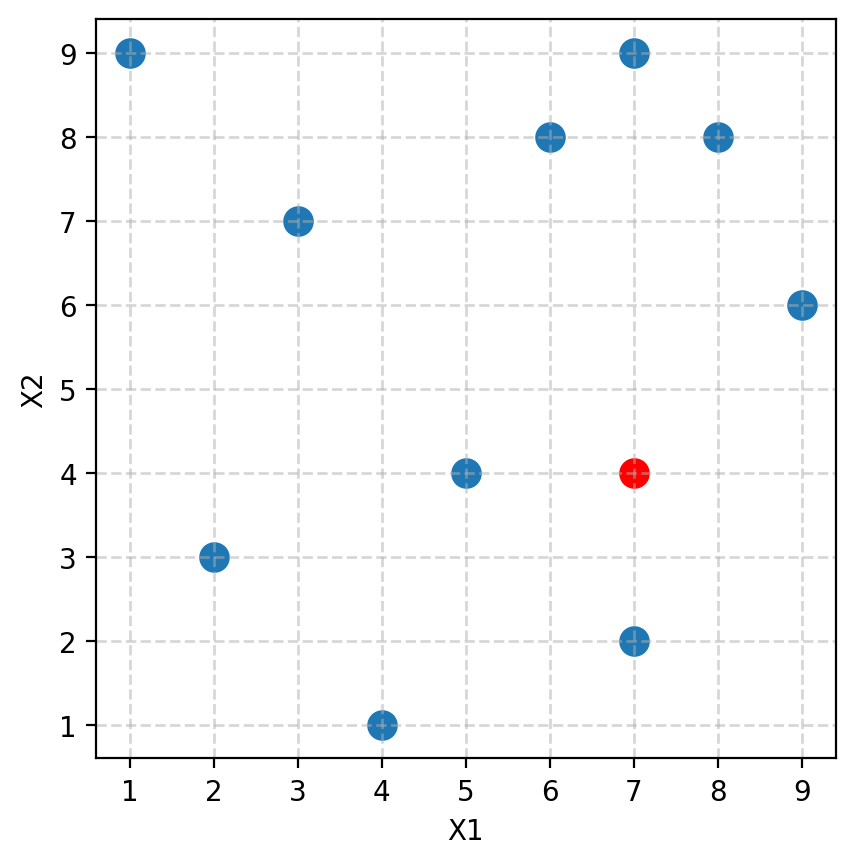

In [6]:
def plot_dataset():
    plt.scatter(X[:, 0], X[:, 1], s=100)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=0.5)
    plt.xticks(np.arange(min(X[:, 0]), max(X[:, 0])+1, 1))
    plt.yticks(np.arange(min(X[:, 1]), max(X[:, 1])+1, 1))
    
    plt.scatter(query_pt[0], query_pt[1], color='red', s=100)
    

plot_dataset()
    

KNN from Sci-kit learn

In [7]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=2, algorithm='brute').fit(X)
distances, indices = nbrs.kneighbors([query_pt])

In [8]:
indices, X[indices], distances

(array([[4, 6]], dtype=int64),
 array([[[5, 4],
         [7, 2]]]),
 array([[2., 2.]]))

Using the naive KNN approach

In [9]:
def pairwise_dist(x: np.ndarray, y: np.ndarray) -> float:
    """
        x: numpy array of shape(d, )
        y: numpy array of shape(d, )
        
        returns the euclidean distance between two d dimensionsal arrays x and y
    """
    return np.sqrt(np.sum((x-y)**2))
    

In [10]:
def distance_vector(X: np.ndarray, y:np.ndarray) -> np.ndarray:
    """
        X: numpy array of shape(n, d)
        query_pt: numpy array of shape(d, )
        
        returns the distance of query_pt from all the points in X
    """
    
    n, d = X.shape
    distances = np.zeros(n)
    for i in range(n):
        distances[i] = pairwise_dist(X[i], query_pt)
    return distances

In [11]:
distances = distance_vector(X, query_pt)

In [12]:
distance_table = pd.DataFrame({
    "Point" : X.tolist(),
    "Distance" : distances
})

In [13]:
distance_table

,Point,Distance
0,"[1, 9]",7.810250
1,"[2, 3]",5.099020
2,"[4, 1]",4.242641
3,"[3, 7]",5.000000
4,"[5, 4]",2.000000
5,"[6, 8]",4.123106
6,"[7, 2]",2.000000
7,"[8, 8]",4.123106
8,"[7, 9]",5.000000
9,"[9, 6]",2.828427


We can see that the minimum distances for the points [5,4] and [7,2]. There are the nearest neighbours and it is the same result as obtained with the sklearn implementation

In [14]:
distance_table.sort_values(by=['Distance'])

,Point,Distance
4,"[5, 4]",2.000000
6,"[7, 2]",2.000000
9,"[9, 6]",2.828427
5,"[6, 8]",4.123106
7,"[8, 8]",4.123106
2,"[4, 1]",4.242641
3,"[3, 7]",5.000000
8,"[7, 9]",5.000000
1,"[2, 3]",5.099020
0,"[1, 9]",7.810250


Using KD trees

In [21]:
class KDNode:
    def __init__(self, point, left=None, right=None, dim=None, points=None):
        """
        point: The coordinate of the point represented by this node
        left: The left child
        right: The right child
        dim: The dimension used to split the data
        points: The set of points stored at the leaf node
        """
        self.point = point
        self.left = left
        self.right = right
        self.dim = dim
        self.points = points
        
    def __repr__(self) -> str:
        points_info = f", n_points={len(self.points)}" if self.points is not None else ""
        return f"KDNode(point={self.point}, dim={self.dim}{points_info})"

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

class KDNode:
    def __init__(self, point=None, points=None, dim=None, left=None, right=None):
        self.point = point
        self.points = points
        self.dim = dim
        self.left = left
        self.right = right

    def __repr__(self):
        return f"KDNode(point={self.point}, dim={self.dim})"


class KDTree:
    def __init__(self, min_samples_split=2):
        self.root = None
        self.min_samples_split = min_samples_split
        
    def build(self, X: np.ndarray):
        self.root = self.split(X)
        
    def split(self, X: np.ndarray, depth: int = 0) -> Optional[KDNode]:
        if len(X) == 0:
            return None
            
        if len(X) < self.min_samples_split:
            return KDNode(point=X[0], points=X, dim=None)
            
        dim = depth % X.shape[1]
        sorted_idx = X[:, dim].argsort()
        X = X[sorted_idx]
        
        median_idx = len(X) // 2
        median_point = X[median_idx]
        
        left_subtree = self.split(X[:median_idx], depth + 1)
        right_subtree = self.split(X[median_idx + 1:], depth + 1)
        
        node = KDNode(
            point=median_point,
            dim=dim,
            left=left_subtree,
            right=right_subtree
        )
        
        if node.left is None and node.right is None:
            node.points = X
            
        return node
    
    def find_leaf_points(self, query_point: np.ndarray) -> np.ndarray:
        def search(node: Optional[KDNode]) -> Optional[np.ndarray]:
            if node is None:
                return None
                
            if node.left is None and node.right is None:
                return node.points
                
            if query_point[node.dim] <= node.point[node.dim]:
                return search(node.left)
            else:
                return search(node.right)
                
        points = search(self.root)
        return points if points is not None else np.array([])
    
    def plot_tree(self, X, query_point=None):
        def plot_node(node, ax):
            if node is None:
                return

            ax.scatter(node.point[0], node.point[1], s=100, c='r', marker='x')

            if node.dim == 0:
                ax.axvline(x=node.point[0], color='k', linestyle='--')
            else:
                ax.axhline(y=node.point[1], color='k', linestyle='--')

            plot_node(node.left, ax)
            plot_node(node.right, ax)

        fig, ax = plt.subplots(figsize=(8, 8))
        ax.scatter(X[:, 0], X[:, 1], s=10, c='b')

        if query_point is not None:
            ax.scatter(query_point[0], query_point[1], s=100, c='g', marker='o', label='Query Point')
            leaf_points = self.find_leaf_points(query_point)
            if len(leaf_points) > 0:
                ax.scatter(leaf_points[:, 0], leaf_points[:, 1], s=50, c='orange', label='Leaf Points')

        plot_node(self.root, ax)
        ax.set_title("KD Tree Partitions with Query Point")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.legend()
        plt.show()


In [90]:
X = np.random.rand(100, 2) * 10

In [94]:
tree = KDTree(min_samples_split=20)
tree.build(X)

In [95]:
tree.print_tree()

KDNode(point=[5.02543074 9.99084053], dim=0)
  KDNode(point=[1.68771966 4.65813701], dim=1)
    KDNode(point=[2.08316981 3.88456564], dim=0)
      KDNode(point=[0.08903298 0.3490094 ], dim=None)
      KDNode(point=[2.54525829 2.26592787], dim=None)
    KDNode(point=[2.04353096 7.62758856], dim=0)
      KDNode(point=[0.02382095 7.65919207], dim=None)
      KDNode(point=[2.17136936 6.77230282], dim=None)
  KDNode(point=[8.89769113 4.15402997], dim=1)
    KDNode(point=[7.00286587 0.9260794 ], dim=0)
      KDNode(point=[5.09064871 0.86960173], dim=None)
      KDNode(point=[7.01801789 1.32435426], dim=None)
    KDNode(point=[7.86783422 8.70348123], dim=0)
      KDNode(point=[5.19245522 8.52942127], dim=None)
      KDNode(point=[7.91463471 5.09058108], dim=None)


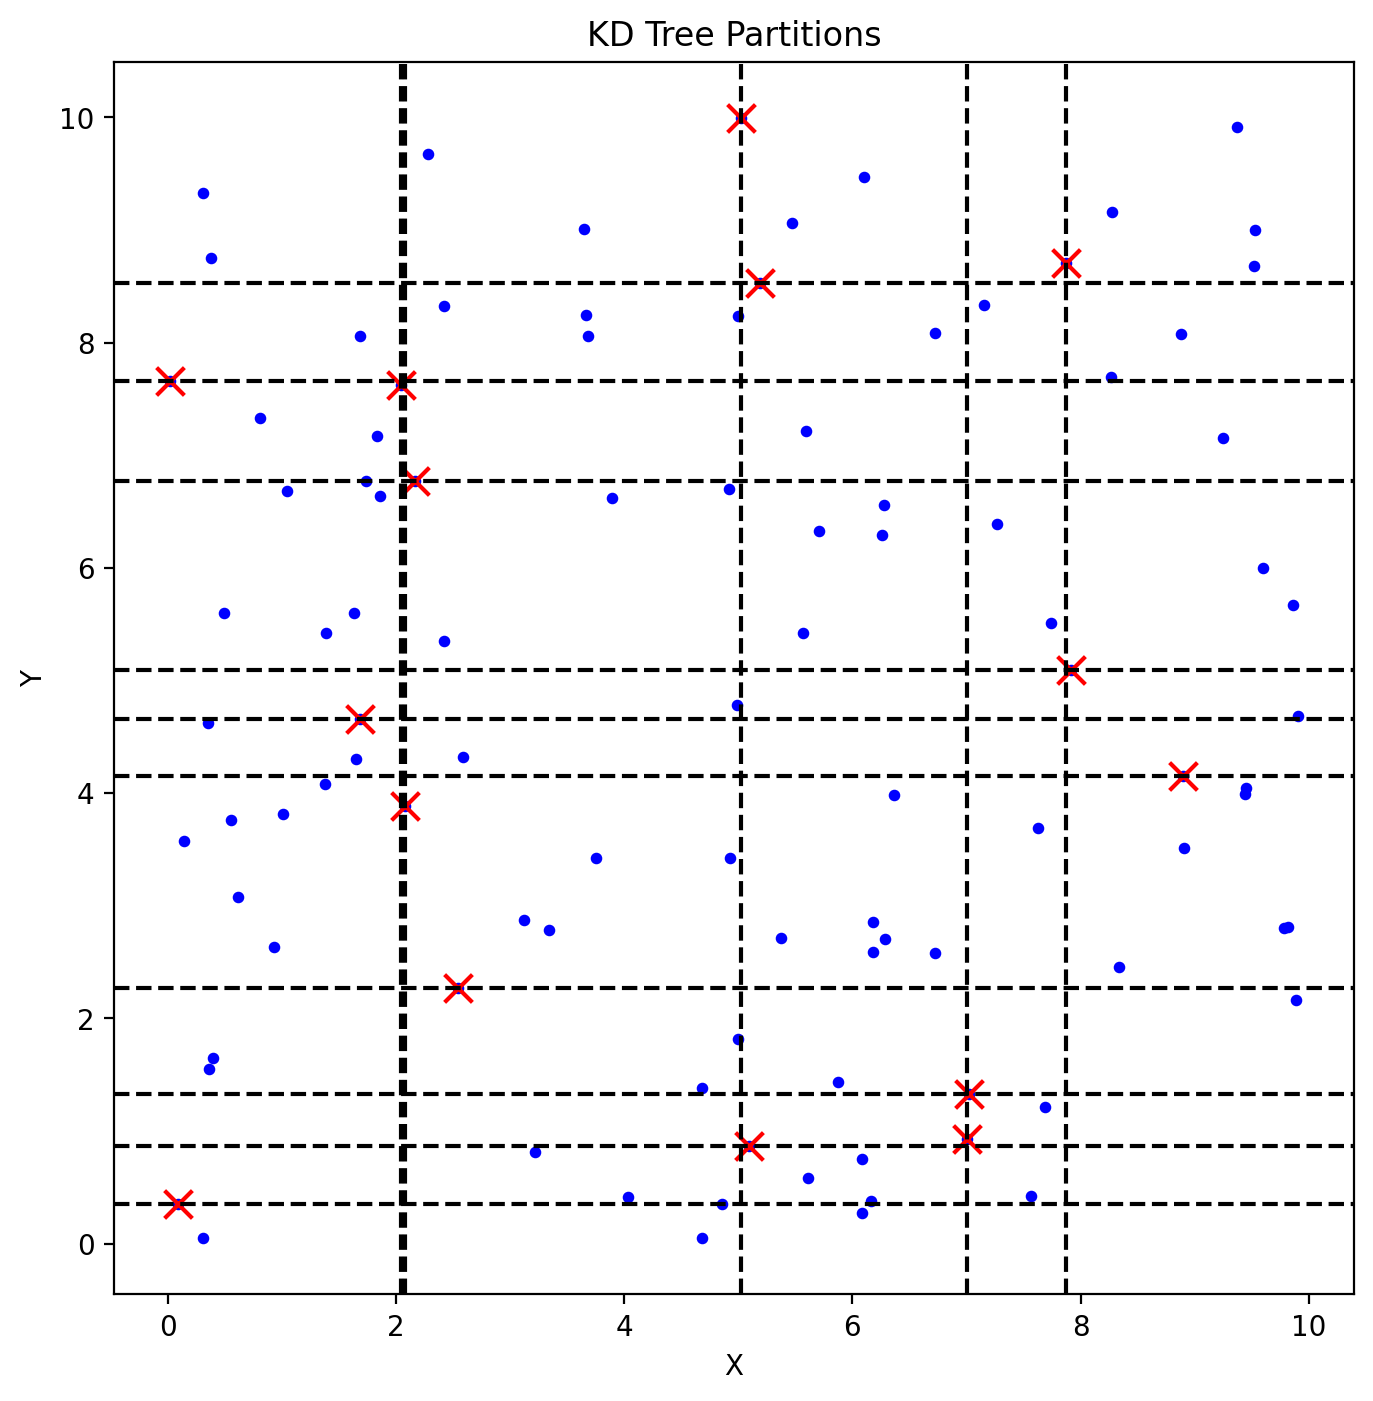

In [96]:
tree.plot_tree(X)

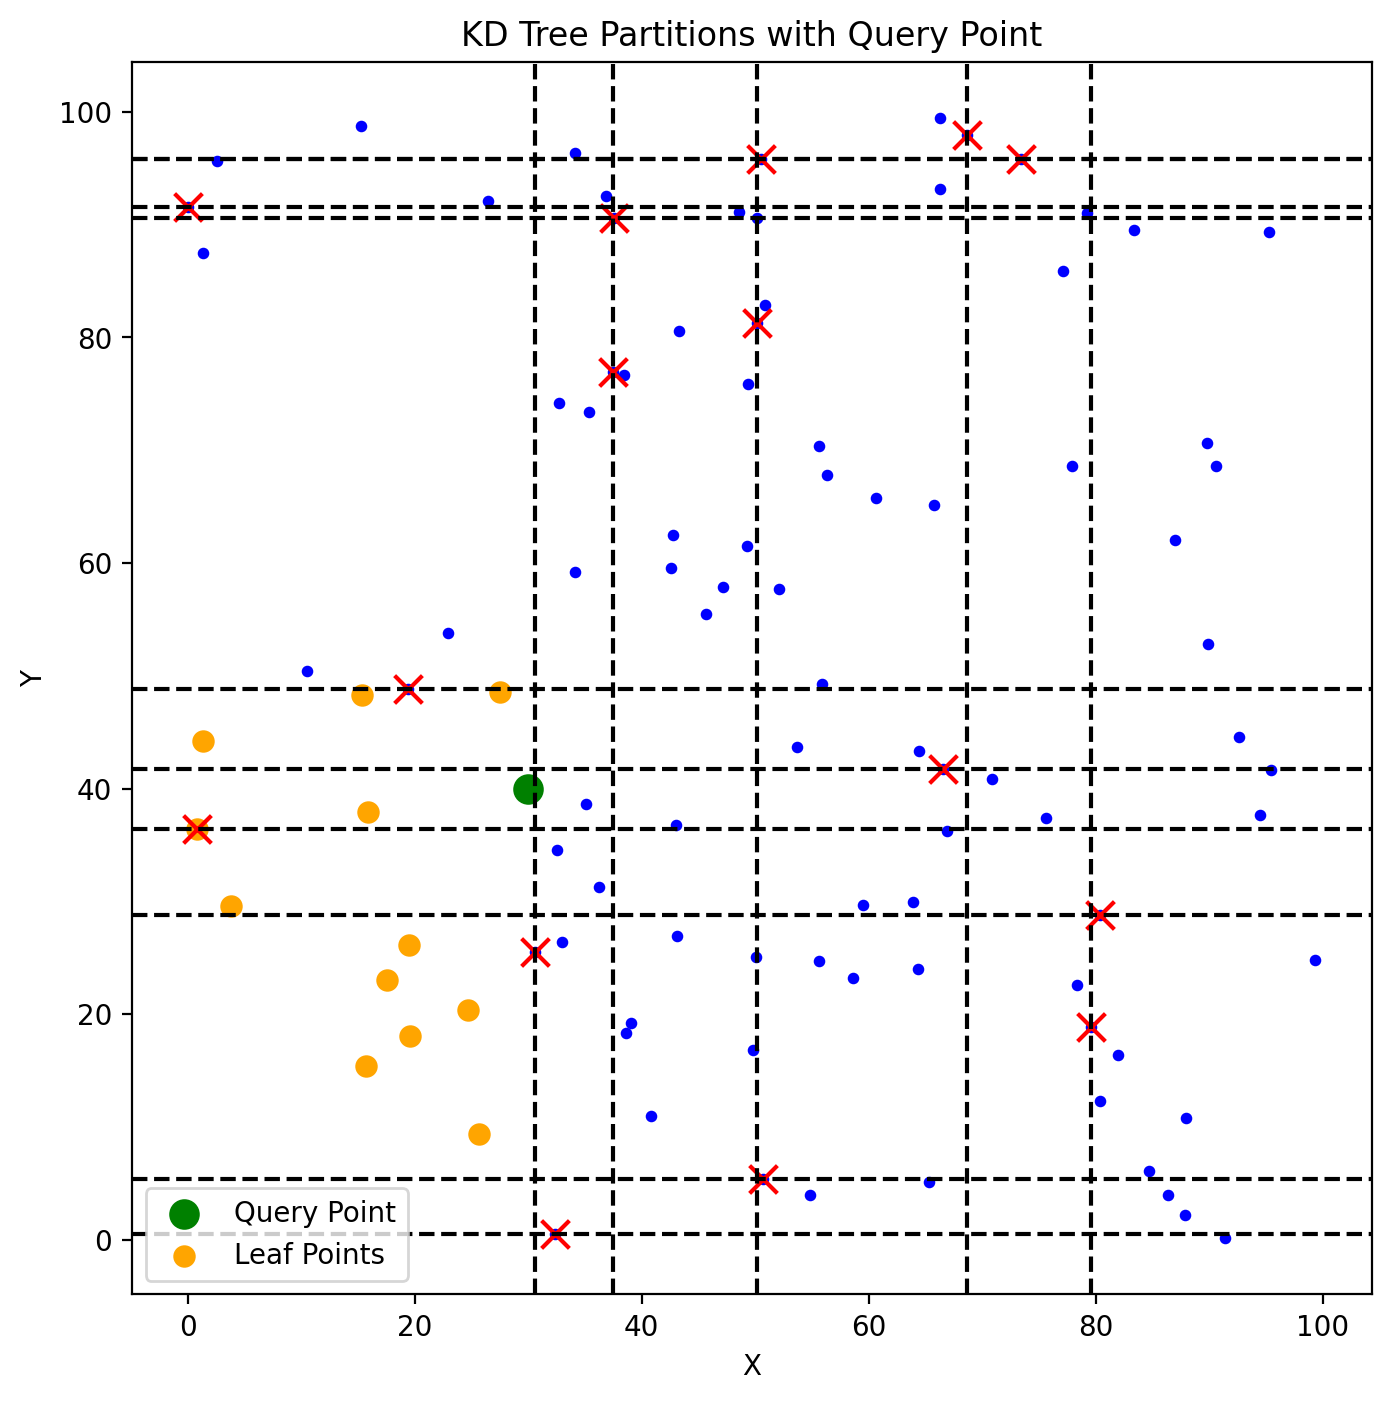

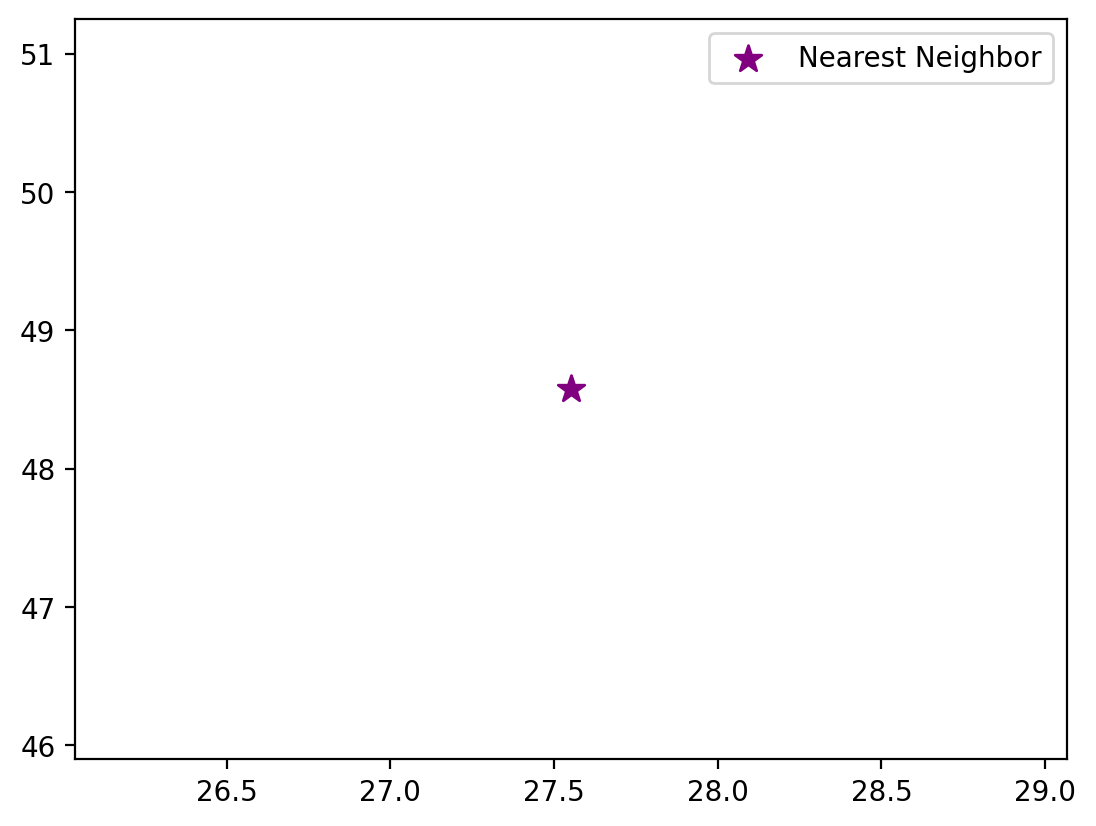

In [98]:
# Generate random 2D points
X = np.random.rand(100, 2) * 100  # 100 points in 2D space

# Initialize and build the KD-tree
tree = KDTree(min_samples_split=20)
tree.build(X)

# Define a query point
query_point = np.array([30, 40])

# Find the nearest neighbor to the query point
leaf_points = tree.find_leaf_points(query_point)
nearest_neighbor = leaf_points[np.argmin(np.linalg.norm(leaf_points - query_point, axis=1))]

# Plot the KD-tree with partitions, query point, and nearest neighbor
tree.plot_tree(X, query_point=query_point)

# Highlight the nearest neighbor
plt.scatter(nearest_neighbor[0], nearest_neighbor[1], s=100, c='purple', marker='*', label='Nearest Neighbor')
plt.legend()
plt.show()
